# Objective - Forecast Close price using (i) SARIMAX & (ii) FBprophet

### Import libraries

In [1]:
#For data
import pandas as pd
import numpy as np

#For Plotting
#import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
# use this so plots will appear directly in the jupyter notebook
%matplotlib inline
# set up the size of the plot's for your notebook
rcParams['figure.figsize'] = 15, 6

#For ARIMA
from pmdarima import auto_arima

#For FBProphet
from fbprophet import Prophet

#Test/Train Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#df = pd.read_csv('DataSet/BAJAJFINSV.csv',index_col=0,parse_dates=True)
#df = pd.read_csv('DataSet/COALINDIA.csv',index_col=0,parse_dates=True)
#df = pd.read_csv('DataSet/MARUTI.csv',index_col=0,parse_dates=True)
df = pd.read_csv('DataSet/NESTLEIND.csv',index_col=0,parse_dates=True)
#df = pd.read_csv('DataSet/NTPC.csv',index_col=0,parse_dates=True)
#df = pd.read_csv('DataSet/POWERGRID.csv',index_col=0,parse_dates=True)
#df = pd.read_csv('DataSet/TATASTEEL.csv',index_col=0,parse_dates=True)
#df = pd.read_csv('DataSet/ULTRACEMCO.csv',index_col=0,parse_dates=True)

In [3]:
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [4]:
df.drop(['Series','Symbol','Prev Close','Last','Turnover','Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)

### Closing Price

<AxesSubplot:xlabel='Date'>

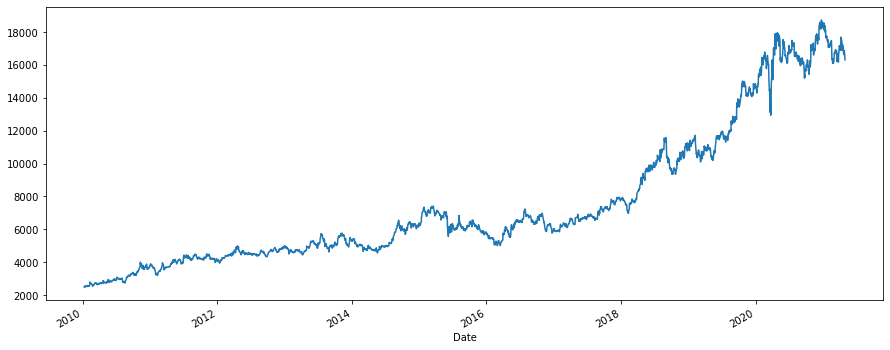

In [5]:
df.Close.plot()

- We need to predict the stock price for a day, but we can't use feature values from the same day because they won't be available at the time of inference. We must employ statistics such as the mean and standard deviation of their lagged values.
- As a proxy for last week and last month metrics, we will use three sets of lagged values: one from the previous day, one from 7 days ago, and one from 30 days ago.

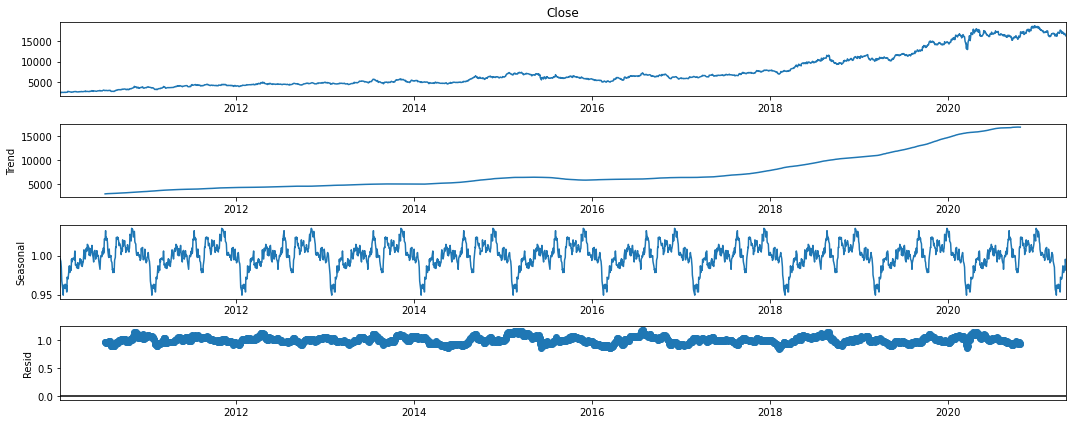

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.Close, model='multiplicative', period=252)
#pylab.rcParams['figure.figsize'] = (14, 9)
result.plot()
plt.show()

In [7]:
df.reset_index(drop=True, inplace=False)
lag_features = ['High', 'Low']
window1 = 3
window2 = 7
window3 = 30

In [8]:
#Mean
#alternative: use 'shift' function instead of 'window+1'
df_mean_3d = df[lag_features].rolling(window = window1+1).mean() 
df_mean_7d = df[lag_features].rolling(window = window2+1).mean()
df_mean_30d = df[lag_features].rolling(window = window3+1).mean()

In [9]:
#Standard Deviation
#alternative: use 'shift' function instead of 'window+1'
df_std_3d = df[lag_features].rolling(window = window1+1).std() 
df_std_7d = df[lag_features].rolling(window = window2+1).std()
df_std_30d = df[lag_features].rolling(window = window3+1).std()

In [10]:
df_std_7d.tail()

,High,Low
Date,,
2021-04-26,270.481825,173.549462
2021-04-27,243.700542,141.754677
2021-04-28,243.719300,150.215307
2021-04-29,249.638556,164.180443
2021-04-30,270.272857,187.701687


In [11]:
#Renaming the columns and merging with orignal dataframe
#Features = High,Low,Volume,Turnover
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"]=df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"]=df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"]=df_mean_30d[feature]
    df[f"{feature}_std_lag{window1}"]=df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"]=df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"]=df_std_30d[feature]

In [12]:
#Fill NAN Values
df.fillna(df.mean(), inplace=True)

In [13]:
df

,Open,High,Low,Close,VWAP,Volume,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30
Date,,,,,,,,,,,,,,,,,,
2010-01-08,2555.00,2575.0,2475.20,2494.65,2529.81,648,7602.624215,7599.61844,7580.367550,82.383726,118.215566,229.635168,7423.14583,7420.118281,7401.468450,78.915324,113.952282,225.778427
2010-01-11,2401.00,2515.0,2400.00,2498.95,2494.44,825,7602.624215,7599.61844,7580.367550,82.383726,118.215566,229.635168,7423.14583,7420.118281,7401.468450,78.915324,113.952282,225.778427
2010-01-12,2540.00,2540.0,2471.35,2502.85,2485.22,68346,7602.624215,7599.61844,7580.367550,82.383726,118.215566,229.635168,7423.14583,7420.118281,7401.468450,78.915324,113.952282,225.778427
2010-01-13,2502.85,2540.0,2480.00,2489.35,2491.94,1032,2542.500000,7599.61844,7580.367550,24.664414,118.215566,229.635168,2456.63750,7420.118281,7401.468450,37.923769,113.952282,225.778427
2010-01-14,2535.00,2595.0,2470.00,2568.20,2510.27,330361,2547.500000,7599.61844,7580.367550,33.788558,118.215566,229.635168,2455.33750,7420.118281,7401.468450,37.156726,113.952282,225.778427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,16799.05,16895.0,16663.65,16870.60,16811.15,152362,17076.075000,17234.90625,17101.666129,283.228922,270.481825,374.433296,16677.48750,16792.231250,16704.759677,148.957082,173.549462,345.502411
2021-04-27,16899.00,16930.0,16750.00,16779.00,16808.88,44651,16953.575000,17151.16250,17102.633871,167.017332,243.700542,373.933140,16642.47500,16755.968750,16709.372581,85.120273,141.754677,345.108078
2021-04-28,16775.00,16831.1,16611.00,16633.80,16681.89,86876,16863.850000,17080.05000,17098.800000,59.400926,243.719300,376.153444,16657.41250,16735.468750,16707.791935,67.113193,150.215307,345.453790


- <b>The target variable to forecast is the Closing Price.</b>
- <b>Test Data - Until 2019</b>
- <b>Validation Data - After 2019</b>

In [14]:
#Test data & Validation Data
df_train = df[df.index<'2019']
df_valid = df[df.index>='2019']

In [15]:
df_train

,Open,High,Low,Close,VWAP,Volume,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30
Date,,,,,,,,,,,,,,,,,,
2010-01-08,2555.00,2575.00,2475.20,2494.65,2529.81,648,7602.624215,7599.61844,7580.367550,82.383726,118.215566,229.635168,7423.14583,7420.118281,7401.468450,78.915324,113.952282,225.778427
2010-01-11,2401.00,2515.00,2400.00,2498.95,2494.44,825,7602.624215,7599.61844,7580.367550,82.383726,118.215566,229.635168,7423.14583,7420.118281,7401.468450,78.915324,113.952282,225.778427
2010-01-12,2540.00,2540.00,2471.35,2502.85,2485.22,68346,7602.624215,7599.61844,7580.367550,82.383726,118.215566,229.635168,7423.14583,7420.118281,7401.468450,78.915324,113.952282,225.778427
2010-01-13,2502.85,2540.00,2480.00,2489.35,2491.94,1032,2542.500000,7599.61844,7580.367550,24.664414,118.215566,229.635168,2456.63750,7420.118281,7401.468450,37.923769,113.952282,225.778427
2010-01-14,2535.00,2595.00,2470.00,2568.20,2510.27,330361,2547.500000,7599.61844,7580.367550,33.788558,118.215566,229.635168,2455.33750,7420.118281,7401.468450,37.156726,113.952282,225.778427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,11056.00,11222.00,10835.55,10923.35,11039.11,34191,11300.187500,11273.36250,10766.746774,95.171638,82.513686,350.012344,11014.03750,10986.637500,10499.253226,144.969022,108.066004,331.824799
2018-12-26,10965.00,10987.00,10745.00,10770.05,10802.50,37172,11239.437500,11246.94375,10786.488710,187.590686,130.083798,344.394304,10922.27500,10968.512500,10518.340323,175.253485,135.314226,328.260309
2018-12-27,10849.00,10969.00,10800.10,10942.85,10888.17,52311,11125.437500,11221.21250,10806.456452,175.394600,162.661350,336.087838,10834.78750,10953.725000,10541.316129,90.499322,147.489334,321.991046


## SARIMAX
Forecasting a time series can be broadly divided into two types.

- If you use only the previous values of the time series to predict its future values, it is called Univariate Time Series Forecasting.

- And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called Multi Variate Time Series Forecasting.

What is SARIMAX?<br></br>
Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors, or SARIMAX, is an extension of the ARIMA class of models.

In [16]:
#df.columns

In [17]:
exogenous_features = ['High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30']

In [18]:
#Syntax used:
#auto_arima(y, X=exogenous variables, suppress_warnings=True, error_action='ignore', trace=True)
#where,
#y : The time-series to which to fit the ARIMA estimator.
#X : An optional 2-d array of exogenous variables. If provided, these variables are used as additional features in the 
#regression operation.
#supress_warnings : If suppress_warnings is True, all of the warnings coming from ARIMA will be squelched.
#error_action : ‘ignore’: Ignores errors
#trace : Whether to print status on the fits.A value of True will print some.

model=auto_arima(df_train.Close,exogenous=df_train[exogenous_features],trace=True,error_action='ignore',supress_warnings = True)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=26031.264, BIC=26134.024, Time=41.367 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=26035.827, BIC=26115.751, Time=5.714 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=26037.354, BIC=26122.987, Time=24.695 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=26037.373, BIC=26123.006, Time=34.014 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=26038.057, BIC=26112.272, Time=37.672 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=26041.376, BIC=26138.426, Time=41.700 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=26041.383, BIC=26138.433, Time=40.487 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=26033.337, BIC=26141.805, Time=53.025 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=26033.214, BIC=26141.683, Time=50.008 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=26039.383, BIC=26130.725, Time=40.351 seconds
Fit ARI

In [19]:
#Syntax
#model.fit(y,X=exogenous variables) - training the data
#where,
#X & y: Same as above
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

ARIMA(order=(4, 1, 0))

In [20]:
#Syntax
#predict(n_periods, X, return_conf_int, alpha)	Forecast future values
#where,
#n_periods : The number of periods in the future to forecast.
#X : Same as above
forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_SARIMAX"] = forecast

<b> Read more on AIC here </b>: https://www.scribbr.com/statistics/akaike-information-criterion/

<AxesSubplot:xlabel='Date'>

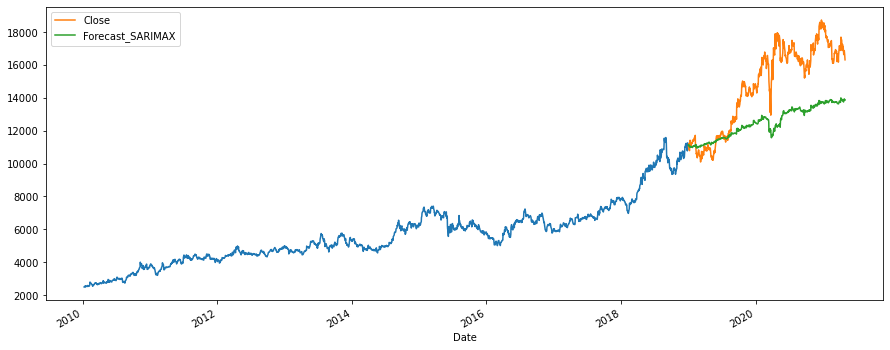

In [21]:
ax = df_train['Close'].plot()
df_valid[['Close','Forecast_SARIMAX']].plot(ax=ax)

In [22]:
aa_rmse = np.round(np.sqrt(mean_squared_error(df_valid.Close,df_valid.Forecast_SARIMAX)),2)
aa_mae = np.round(mean_absolute_error(df_valid.Close,df_valid.Forecast_SARIMAX),2)
print('RMSE of SARIMAX',aa_rmse)
print('MAE of SRIMAX',aa_mae)

RMSE of SARIMAX 2797.73
MAE of SRIMAX 2352.98


### Insights

The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude

Both the MAE and RMSE can range from 0 to ∞. They are negatively-oriented scores: Lower values are better.

Further reading, visit here: https://thedatascientist.com/performance-measures-rmse-mae/

## FBprophet

Prophet is an open-source time series model developed by Facebook. It was released in early 2017.

In [23]:
df_train = df_train.reset_index()
df_valid = df_valid.reset_index()

In [24]:
model_fbp = Prophet(daily_seasonality=True)

#Additional regressors can be added to the linear part of the model using the add_regressor method or function. 
#A column with the regressor value will need to be present in both the fitting and prediction dataframes. 

for feature in exogenous_features:
    model_fbp.add_regressor(feature)
    
#The input to Prophet is always a dataframe with two columns: ds and y. 
#The ds (datestamp) column should be of a format YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. 
#The y column must be numeric, and represents the measurement we wish to forecast.
    
model_fbp.fit(df_train[['Date','Close',] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"}))
forecast1 = model_fbp.predict(df_valid[['Date','Close'] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"}))

df_valid['Forecast_Prophet'] = forecast1.yhat.values

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


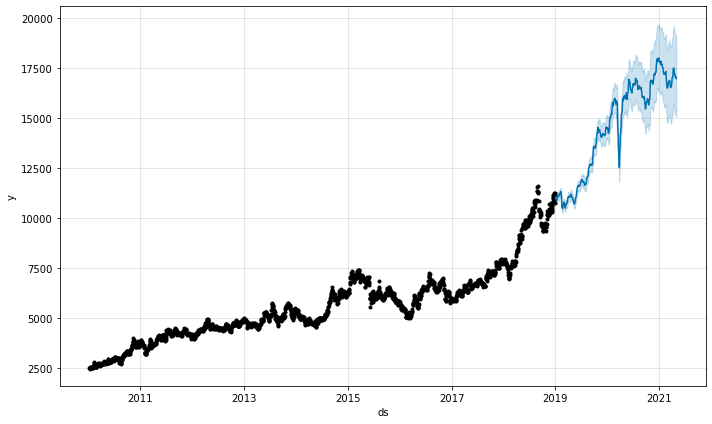

In [25]:
fig = model_fbp.plot(forecast1)

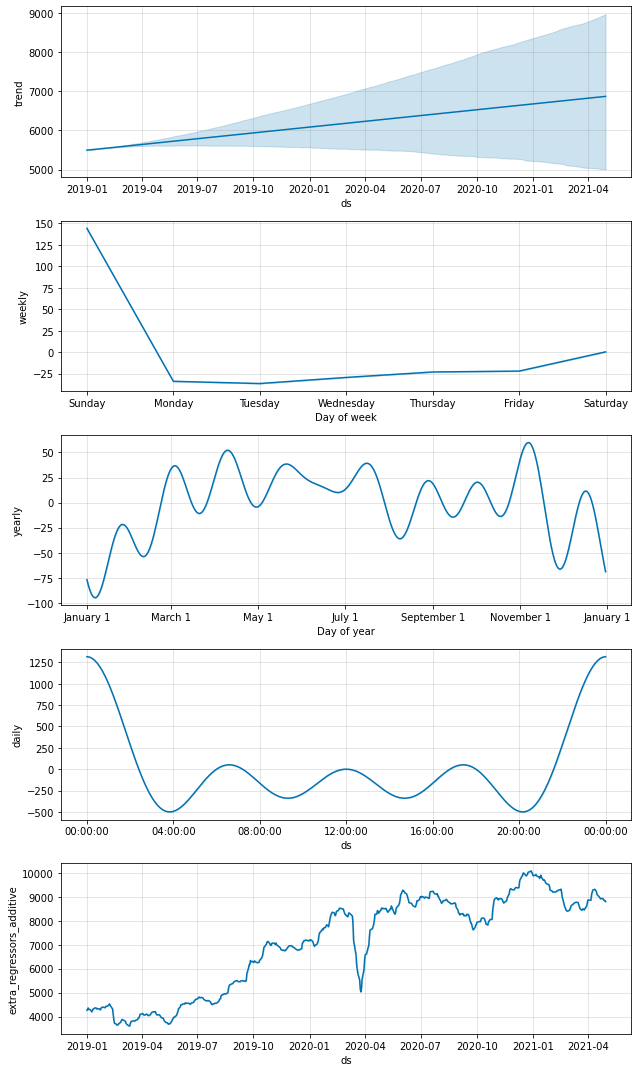

In [26]:
fig = model_fbp.plot_components(forecast1)

In [27]:
fb_rmse = np.round(np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_Prophet)),2)
fb_mae = np.round(mean_absolute_error(df_valid.Close, df_valid.Forecast_Prophet),2)

print("RMSE SARIMAX:", aa_rmse)
print("RMSE Prophet:", fb_rmse)
print("\nMAE SARIMAX:", aa_mae)
print("MAE Prophet:", fb_mae)

RMSE SARIMAX: 2797.73
RMSE Prophet: 497.73

MAE SARIMAX: 2352.98
MAE Prophet: 322.78


### References
[End-to-End Time Series Analysis and Forecasting: a Trio of SARIMAX, LSTM and Prophet](https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8)

[Predicting Stock Prices Using Facebook’s Prophet Model](https://medium.com/analytics-vidhya/predicting-stock-prices-using-facebooks-prophet-model-b1716c733ea6)

[Time Series Analysis with Facebook Prophet: How it works and How to use it](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)
